<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TL;DR" data-toc-modified-id="TL;DR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TL;DR</a></span></li><li><span><a href="#Import-libs" data-toc-modified-id="Import-libs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libs</a></span></li><li><span><a href="#Step-by-step" data-toc-modified-id="Step-by-step-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step-by-step</a></span><ul class="toc-item"><li><span><a href="#Debug" data-toc-modified-id="Debug-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Debug</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Traffic-poisson_exp_compute_2e6" data-toc-modified-id="Traffic-poisson_exp_compute_2e6-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Traffic poisson_exp_compute_2e6</a></span><ul class="toc-item"><li><span><a href="#Choose-samples-for-1lb" data-toc-modified-id="Choose-samples-for-1lb-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Choose samples for 1lb</a></span></li></ul></li><li><span><a href="#Run-heuristics" data-toc-modified-id="Run-heuristics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run heuristics</a></span></li><li><span><a href="#Run-maglev" data-toc-modified-id="Run-maglev-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Run maglev</a></span></li><li><span><a href="#Run-nf-llf" data-toc-modified-id="Run-nf-llf-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run nf-llf</a></span></li><li><span><a href="#Run-nf-po2" data-toc-modified-id="Run-nf-po2-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Run nf-po2</a></span></li><li><span><a href="#Run-weighted" data-toc-modified-id="Run-weighted-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run weighted</a></span></li></ul></li></ul></div>

# TL;DR
This notebook is used to do unit test for each candidate load balancing method implemented for testbed.

Experiment setup:
- 1 lb
- 12 as
- poisson_lognormal trace
- [110, 112, 114, 116, 118, 120] traffic rate
- 4 as w/ colocated workload 

Candidate methods:
- Maglev (ECMP)
- Static-ws (WCMP)
- NF-LLF (LSQ)
- NF-PO2 (LSQ2)
- Heuristic-ada

# Import libs

In [1]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time

# Step-by-step

## Debug

In [30]:
tu.umount_image()

In [29]:
tu.mount_image(tu.CONF['global']['path']['orig_img'])

In [7]:
tu.umount_image()
# mount base image
tu.mount_new_image(tu.CONF['global']['path']['orig_img'], tu.CONF['global']['path']['base_img'])

In [81]:
img = tu.CONF['global']['path']['base_img']
cmd = "sudo modprobe nbd max_part=8;\
    sudo qemu-nbd --connect=/dev/nbd0 {};\
    sudo mount -o loop /dev/nbd0p1 {};\
    \n".format(img, tu.LOOP_DIR)
print(cmd)

sudo modprobe nbd max_part=8;    sudo qemu-nbd --connect=/dev/nbd0 /home/yzy/Load-Balancer/data/img/lb-vpp-base.img;    sudo mount -o loop /dev/nbd0p1 /mnt/loop;    



In [84]:
cmd = "sudo chown 1000:1000 {0}/home/cisco/*;\
        sudo umount {0}/;\
        sudo qemu-nbd --disconnect /dev/nbd0;\n".format(tu.LOOP_DIR)
print(cmd)

sudo chown 1000:1000 /mnt/loop/home/cisco/*;        sudo umount /mnt/loop/;        sudo qemu-nbd --disconnect /dev/nbd0;



## Unit test

In [197]:
lb_method = 'maglev'
trace='poisson_benchmark'
experiment='atc-overhead-dev'
sample='rate_500.csv'
from_orig=False
config_file_prefix='1x-1lb-88core'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=None
ep = 1

In [198]:
server_id = 1
if twist:
    config_file_prefix += '-twist'
config_file = config_file_prefix+'-'+str(server_id)
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
ip_remote = tu.COMMON_CONF['net']['physical_server_ip']


task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=1x-1lb-88core
alias=1x-1lb-88core
>> run task poisson_benchmark-maglev-rate_500-1x-1lb-88core


In [199]:
for server_id in [0, 2, 3]:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
    
    tu.subprocess.Popen(cmd, shell=True)

In [200]:
tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

Create LB node image...


In [201]:
tu.runall()
time.sleep(10)

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
node_server_14 ready: ssh -p 9014 cisco@localhost
node_server_15 ready: ssh -p 9015 cisco@localhost
node_server_16 ready: ssh -p 9016 cisco@localhost
node_server_17 ready: ssh -p 9017 cisco@localhost
node_server_18 ready: ssh -p 9018 cisco@localhost
node_server_19 ready: ssh -p 9019 cisco@localhost


In [202]:
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)

LB Node 0: pass


In [203]:
# start gathering at LB node
for lb in tu.NODES['lb']:
    lb.run_init_bg()

In [204]:
# run traffic
t0 = time.time()
cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
    experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
if colocate:
    cmd += ' --colocate {}'.format(colocate)
    
tu.subprocess_cmd(cmd)
print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
# time.sleep(5)

Trace replay over w/ total time: 225.001s


In [205]:
# fetch results from nodes
for server_id in [0, 2, 3]:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
#     if server_id == 0:
    cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)

In [206]:
for lb in tu.NODES['lb']:
    lb.fetch_result(task_dir, ep)

In [207]:
tu.shutall()

## Pipeline

In [80]:
def run_pipeline(
    lb_method = 'maglev',
    trace='poisson_benchmark',
    experiment='atc-overhead',
    sample='rate_500.csv',
    from_orig=None,
    config_file_prefix='1x-1lb-88core',
    colocate=None,
    colocate_freq=0.0001,
    twist=False,
    clip_n=None,
    eps = [1, 2, 3]
):
    server_id = 1
    if twist:
        config_file_prefix += '-twist'
    config_file = config_file_prefix+'-'+str(server_id)
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
    ip_remote = tu.COMMON_CONF['net']['physical_server_ip']

    for ep in eps:

        print("episode {}".format(ep))
        task_name, task_dir, nodes = tu.init_task_info(
            experiment=experiment,
            lb_method=lb_method,
            trace=trace,
            sample=sample,
            filename=config_file+'.json',
            colocate=colocate,
            colocate_freq=colocate_freq,
            alias=config_file_prefix
        )

        print(">> run task {}".format(task_name))

        for server_id in [0, 2, 3]:
            if clip_n and server_id == 0:
                clip_str = '-n {}'.format(clip_n)
            else:
                clip_str = ''

            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)

            tu.subprocess.Popen(cmd, shell=True)

        tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

        tu.runall()
        time.sleep(10)

        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)

        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
        if colocate:
            cmd += ' --colocate {}'.format(colocate)

        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
        # time.sleep(5)

        # fetch results from nodes
        for server_id in [0, 2, 3]:
            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
            if server_id == 0:
                cmd += ' --shutdown'
            tu.subprocess.Popen(cmd, shell=True)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, ep)

        tu.shutall()

In [81]:
for method in ['maglev', 'ecmp']:
    print("=== method: {} ===".format(method))
    eps = range(2, 10)
    run_pipeline(
        lb_method=method,
        eps=eps)

=== method: maglev ===
episode 2
init_task_info: alias=1x-1lb-88core
alias=1x-1lb-88core
>> run task poisson_benchmark-maglev-rate_500-1x-1lb-88core
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
node_server_14 ready: ssh -p 9014 cisco@localhost
node_server_15 ready: ssh -p 9015 cisco@localhost
node_server_16 ready: ssh -p 9016 cisco@localhost
node_server_17 ready: ssh -p 9017 cisco@localhost
node_server_18 ready: ssh -p 9018 cisco@localhost
node_server_19 ready: ssh -p 9019 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 228.434s
episode 3
init_task_info: alias=1x-1lb-88core
alias=1x-1lb-88core
>> run task poisson_benchmark-maglev-rate_500-1x-1lb-88core
Create LB node image...
node_lb_0 ready: ssh -p 8

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_server_12 ready: ssh -p 9012 cisco@localhost
node_server_13 ready: ssh -p 9013 cisco@localhost
node_server_14 ready: ssh -p 9014 cisco@localhost
node_server_15 ready: ssh -p 9015 cisco@localhost
node_server_16 ready: ssh -p 9016 cisco@localhost
node_server_17 ready: ssh -p 9017 cisco@localhost
node_server_18 ready: ssh -p 9018 cisco@localhost
node_server_19 ready: ssh -p 9019 cisco@localhost
LB Node 0: pass
Trace replay over w/ total time: 230.383s
episode 5
init_task_info: alias=1x-1lb-88core
alias=1x-1lb-88core
>> run task poisson_benchmark-ecmp-rate_500-1x-1lb-88core
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_9 ready: ssh -p 9009 cisco@localhost
node_server_10 ready: ssh -p 9010 cisco@localhost
node_server_11 ready: ssh -p 9011 cisco@localhost
node_s

## Plot Results

In [60]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from math import pi
import time
import datetime
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu

from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import json
import math
import random

%matplotlib inline
min_max_scaler = preprocessing.MinMaxScaler()

sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

In [61]:
'''
write data to json file
'''
def json_write2file(data, filename):
    with open(filename, "w") as write_file:
        json.dump(data, write_file, indent=4) # w/ indent the file looks better

'''
read data from json file
'''
def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)
    
# @desc:   read lines from a file into a list
# @params: (str)filename
# @return: list of strings
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

In [157]:
data_dir = '../../data/results/atc-overhead'
methods = ['maglev', 'ecmp', 'ecmp_all', 'pcap']
conf = '1x-1lb-88core'
trace = 'poisson_benchmark'
rate = 500

In [66]:
!ls $data_dir/poisson_benchmark/ecmp/rate_500-1x-1lb-88core

0_log_ep0  0_log_ep4  0_log_ep8      trace_ep3.log  trace_ep7.log
0_log_ep1  0_log_ep5  0_log_ep9      trace_ep4.log  trace_ep8.log
0_log_ep2  0_log_ep6  trace_ep1.log  trace_ep5.log  trace_ep9.log
0_log_ep3  0_log_ep7  trace_ep2.log  trace_ep6.log


In [158]:
clib_dict = {
}
for m in methods:
    clib_dict[m] = {
        0: [],
        1: [],
        2: []
    }
    eps = [1]
    for ep in eps:
        lines = [l.split('@dt = ')[-1].strip(' ') for l in read_file(os.path.join(data_dir, trace, m, 'rate_{:d}-{}'.format(rate, conf), '0_log_ep{}/clib.log'.format(ep))) if '@dt' in l]
        for l in lines:
            dt, packet_type = float(l.split('|')[0].strip(']')), int(l.split('|')[1].strip(']'))
            clib_dict[m][packet_type].append(dt)

In [163]:
lines = read_file(os.path.join(data_dir, trace, m, 'rate_{:d}-{}'.format(rate, conf), 'pcap2mem.log'))
pcap_first = [int(l.split("| ")[-1]) for l in lines if '0 | ' in l]
pcap_data = [int(l.split("| ")[-1]) for l in lines if '1 | ' in l]

In [166]:
clib_dict[m][0] = [i+j for i, j in zip(clib_dict[m][0], pcap_first)]

In [167]:
clib_dict[m][1] = [i+j for i, j in zip(clib_dict[m][1], pcap_first)]

In [224]:
COLORS_DICT = {
    'ecmp_all': "#508fc3", 
    'maglev': "#634295",
    'ecmp': "#559d3f",
    'pcap': "#d1342b",
}

MARKER_DICT = {
    'maglev':       ".",
    'ecmp_all':    "x",
    'ecmp': '2',
    'pcap': '+',
}

LINESTYLE_DICT = {
    'maglev':       "--",
    'ecmp_all':    "-",
}

METHOD_MAPPER = {
    'ecmp': "11 Features", 
    'ecmp_all': "73 features", 
    'maglev': "0 Feature", 
    'pcap': "PCAP Log",
}

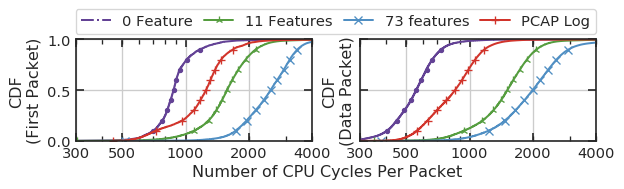

In [226]:
cpu_scale = 1
mem_scale = 3.94444/100
text_x = 350
fig, axs = plt.subplots(1, 2, figsize=(7,1.4), dpi=96, sharex=False, sharey=True)
plt.sca(axs[0])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][0]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
# plt.grid()
plt.ylabel("CDF\n(First Packet)")
plt.xscale('log')
plt.xticks([300, 500, 1000, 2000, 4000], [300, 500, 1000, 2000, 4000])
plt.xlim([300, 4000])


plt.sca(axs[1])

# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][1]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])

plt.xscale('log')
plt.xlim([300, 4000])
plt.xticks([300, 500, 1000, 2000, 4000], [300, 500, 1000, 2000, 4000])

plt.ylabel("CDF\n(Data Packet)")
# plt.xlabel('Used RAM (GiB)')
plt.suptitle("Number of CPU Cycles Per Packet", x=0.5, y=-.05, fontsize=12);
# plt.grid()
plt.ylim([0, 1])
plt.show()

In [242]:
print("avg Additional cycles {:.3f} {:.3f}x than w/o Aquarius {}".format(np.mean(clib_dict['ecmp_all'][0]), (np.mean(clib_dict['ecmp_all'][0]) / np.mean(clib_dict['maglev'][0])), np.mean(clib_dict['maglev'][0])))
print("avg Additional cycles {:.3f} {:.3f}x than w/o Aquarius".format(np.mean(clib_dict['ecmp'][0]), (np.mean(clib_dict['ecmp'][0]) / np.mean(clib_dict['maglev'][0]))))
print("avg Additional cycles {:.3f} {:.3f}x than w/o Aquarius".format(np.mean(clib_dict['pcap'][0]), (np.mean(clib_dict['pcap'][0]) / np.mean(clib_dict['maglev'][0]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp_all'][0]) - np.mean(clib_dict['maglev'][0]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp'][0]) - np.mean(clib_dict['maglev'][0]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['pcap'][0]) - np.mean(clib_dict['maglev'][0]))))

avg Additional cycles 2609.019 2.781x than w/o Aquarius 938.2322209436134
avg Additional cycles 1635.838 1.744x than w/o Aquarius
avg Additional cycles 1295.284 1.381x than w/o Aquarius
avg Additional cycles 1670.787 than w/o Aquarius
avg Additional cycles 697.606 than w/o Aquarius
avg Additional cycles 357.052 than w/o Aquarius


In [188]:
print("avg Additional cycles {:.3f}x than w/o Aquarius {:.3f}".format((np.mean(clib_dict['ecmp_all'][0]+clib_dict['ecmp_all'][1]) / np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1])), np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1])))
print("avg Additional cycles {:.3f}x than w/o Aquarius".format((np.mean(clib_dict['ecmp'][0]+clib_dict['ecmp'][1]) / np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f}x than w/o Aquarius".format((np.mean(clib_dict['pcap'][0]+clib_dict['pcap'][1]) / np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp_all'][0]+clib_dict['ecmp_all'][1]) - np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp'][0]+clib_dict['ecmp'][1]) - np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['pcap'][0]+clib_dict['pcap'][1]) - np.mean(clib_dict['maglev'][0]+clib_dict['maglev'][1]))))

avg Additional cycles 4.445x than w/o Aquarius 585.755
avg Additional cycles 2.718x than w/o Aquarius
avg Additional cycles 1.550x than w/o Aquarius
avg Additional cycles 2017.956 than w/o Aquarius
avg Additional cycles 1006.426 than w/o Aquarius
avg Additional cycles 321.999 than w/o Aquarius


In [243]:
print("avg Additional cycles {:3f} {:.3f}x than w/o Aquarius {:.3f}".format(np.mean(clib_dict['ecmp_all'][1]), (np.mean(clib_dict['ecmp_all'][1]) / np.mean(clib_dict['maglev'][1])), np.mean(clib_dict['maglev'][1])))
print("avg Additional cycles {:3f} {:.3f}x than w/o Aquarius".format(np.mean(clib_dict['ecmp'][1]), (np.mean(clib_dict['ecmp'][1]) / np.mean(clib_dict['maglev'][1]))))
print("avg Additional cycles {:3f} {:.3f}x than w/o Aquarius".format(np.mean(clib_dict['pcap'][1]), (np.mean(clib_dict['pcap'][1]) / np.mean(clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp_all'][1]) - np.mean(clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['ecmp'][1]) - np.mean(clib_dict['maglev'][1]))))
print("avg Additional cycles {:.3f} than w/o Aquarius".format((np.mean(clib_dict['pcap'][1]) - np.mean(clib_dict['maglev'][1]))))

avg Additional cycles 2602.684370 4.516x than w/o Aquarius 576.357
avg Additional cycles 1583.798840 2.748x than w/o Aquarius
avg Additional cycles 885.040526 1.536x than w/o Aquarius
avg Additional cycles 2026.327 than w/o Aquarius
avg Additional cycles 1007.442 than w/o Aquarius
avg Additional cycles 308.684 than w/o Aquarius


In [227]:
fig.savefig('../../data/figures/atc/application/classification/cycle.pdf', transparent=True, bbox_inches='tight')

### Compare System Usage

In [212]:
def pd_dataframe_from_csv(filename, sep=',', index_col=False, astype=None):
    df = pd.read_csv(filename, sep=sep, encoding='utf-8', index_col=index_col)
    if astype: df = df.astype(astype)
    return df.dropna()

data_dir = '../../data/results/atc-overhead'
methods = ['maglev', 'ecmp', 'ecmp_all', 'pcap']
trace = 'poisson_benchmark'
rate = 500
folder = '/home/yzy/Load-Balancer/data/results/atc-overhead/poisson_benchmark/'
config = 'rate_500-1x-1lb-88core'
n_eps = {
    'ecmp': [1],
    'maglev': [1],
    'ecmp_all': [1],
    'pcap': [1]
}

dfs = []
data_all = {
    method: pd.concat([pd_dataframe_from_csv(os.path.join(folder, method, config, '0_log_ep{}'.format(ep), 'usage.log')) for ep in n_eps[method]]) for method in methods
}

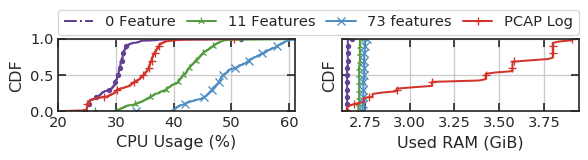

In [228]:
cpu_scale = 1
mem_scale = 3.94444/100
text_x = 350
fig, axs = plt.subplots(1, 2, figsize=(7,1), dpi=96, sharex=False, sharey=True)
plt.sca(axs[0])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = data_all[m]['cpu_usage'].values*cpu_scale
    data = np.array([v for v in data_all[m]['cpu_usage'].values if v > 18.5]) * cpu_scale
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
# plt.grid()
plt.ylabel("CDF")
plt.xlabel("CPU Usage (%)")
plt.xlim(np.array([20, 61])*cpu_scale)
# plt.xlim(np.array([24.5, 42])*cpu_scale)

# plt.xticks([600, 1000, 2000, 4000], ['', '', '', ''])

plt.sca(axs[1])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    if m in ['pcap']:
        data = np.array([v+33.6 for v in data_all[m]['used_ram'].values if v < 66.4]) * mem_scale
    else:
        data = np.array([v for v in data_all[m]['used_ram'].values]) * mem_scale
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])

plt.ylabel("CDF")
plt.xlabel('Used RAM (GiB)')
# plt.grid()
# plt.xlim(np.array([66.5, 71])*mem_scale)
plt.xlim(np.array([66.5, 100])*mem_scale)
plt.xticks([2.75, 3, 3.25, 3.5, 3.75])
plt.ylim([0, 1])
plt.show()

In [229]:
fig.savefig('../../data/figures/atc/application/classification/system.pdf', transparent=True, bbox_inches='tight')

In [244]:
print("Median Additional CPU usage {:.3f} {:.3f}x than w/o Aquarius {:.3f}".format(np.mean(data_all['ecmp_all']['cpu_usage'].values*cpu_scale), (np.mean(data_all['ecmp_all']['cpu_usage'].values*cpu_scale) / np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)), np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)))
print("Median Additional RAM usage {:.3f}/{:.3f} = {:.3f}%".format(np.mean(data_all['ecmp_all']['used_ram'].values*mem_scale)*1000, np.mean(data_all['maglev']['used_ram'].values*mem_scale)*1000, (np.mean(data_all['ecmp_all']['used_ram'].values*mem_scale) / np.mean(data_all['maglev']['used_ram'].values*mem_scale))))

Median Additional CPU usage 49.716 1.675x than w/o Aquarius 29.687
Median Additional RAM usage 2743.590/2652.203 = 1.034%


In [245]:
print("Median Additional CPU usage {:.3f} {:.3f}x than w/o Aquarius {:.3f}".format(np.mean(data_all['ecmp']['cpu_usage'].values*cpu_scale), (np.mean(data_all['ecmp']['cpu_usage'].values*cpu_scale) / np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)), np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)))
print("Median Additional RAM usage {:.3f}/{:.3f} = {:.3f}%".format(np.mean(data_all['ecmp']['used_ram'].values*mem_scale)*1000, np.mean(data_all['maglev']['used_ram'].values*mem_scale)*1000, (np.mean(data_all['ecmp']['used_ram'].values*mem_scale) / np.mean(data_all['maglev']['used_ram'].values*mem_scale))))

Median Additional CPU usage 40.858 1.376x than w/o Aquarius 29.687
Median Additional RAM usage 2718.966/2652.203 = 1.025%


In [250]:
print("Median Additional CPU usage {:.3f} {:.3f}x than w/o Aquarius {:.3f}".format(np.mean(data_all['pcap']['cpu_usage'].values*cpu_scale), (np.mean(data_all['pcap']['cpu_usage'].values*cpu_scale) / np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)), np.mean(data_all['maglev']['cpu_usage'].values*cpu_scale)))
print("Median Additional RAM usage {:.3f}/{:.3f} = {:.3f}%".format(np.mean([v+33.6 for v in data_all[m]['used_ram'].values if v < 66.4])*mem_scale*1000, np.mean(data_all['maglev']['used_ram'].values*mem_scale)*1000, (np.mean([v+33.6 for v in data_all['pcap']['used_ram'].values if v < 66.4]) / np.mean(data_all['maglev']['used_ram'].values))))

Median Additional CPU usage 31.480 1.060x than w/o Aquarius 29.687
Median Additional RAM usage 3305.149/2652.203 = 1.246%
